In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report,accuracy_score,f1_score,recall_score,precision_score,roc_auc_score,roc_curve,confusion_matrix)

In [281]:
df=pd.read_csv("telecom_churn.csv")
df.head(10)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17
5,CUST000006,Female,0.0,No,Yes,51.0,Yes,Fiber optic,67.69,3448.78,No,2022-05-21
6,CUST000007,Male,0.0,No,No,NaN,Yes,NaN,29.10,1838.4,No,2022-12-22
7,CUST000008,Male,0.0,NaN,NaN,32.0,Yes,DSL,98.40,3101.47,Yes,2020-04-17
8,CUST000009,Male,0.0,No,NaN,15.0,Yes,NaN,48.37,NaN,No,2022-11-25
9,CUST000010,Female,0.0,No,Yes,NaN,Yes,DSL,72.30,4735.31,No,NaN


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB


In [283]:
df.isnull().sum()

CustomerID             0
Gender             18213
SeniorCitizen      18139
Partner            18006
Dependents         17997
Tenure             17999
PhoneService       17904
InternetService    18421
MonthlyCharges     18096
TotalCharges       19743
Churn                  0
Timestamp          18243
dtype: int64

In [284]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['MonthlyCharges']=pd.to_numeric(df['MonthlyCharges'],errors="coerce")
df['Tenure']=pd.to_numeric(df['Tenure'],errors="coerce")
df.drop(['CustomerID','Timestamp'],axis=1,inplace=True)

<Axes: xlabel='InternetService', ylabel='count'>

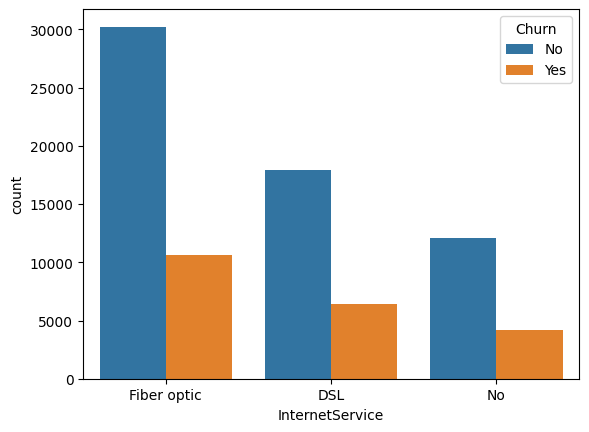

In [285]:
sns.countplot(x='InternetService', hue='Churn', data=df)


<Axes: xlabel='Tenure', ylabel='TotalCharges'>

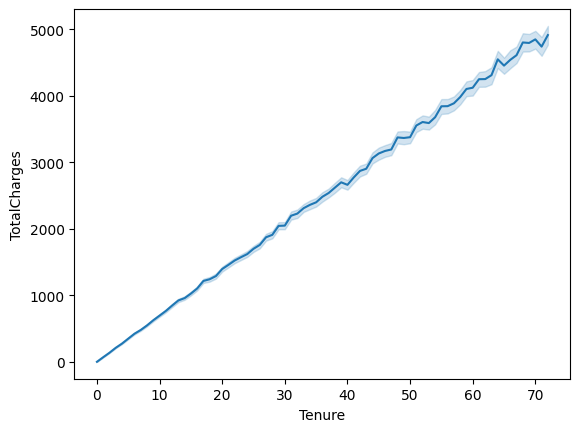

In [286]:
sns.lineplot(data=df, x='Tenure', y='TotalCharges')


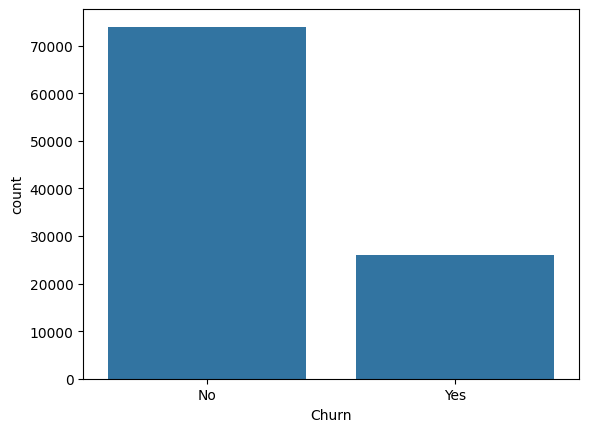

In [287]:
sns.countplot(x='Churn',data=df)
plt.show()

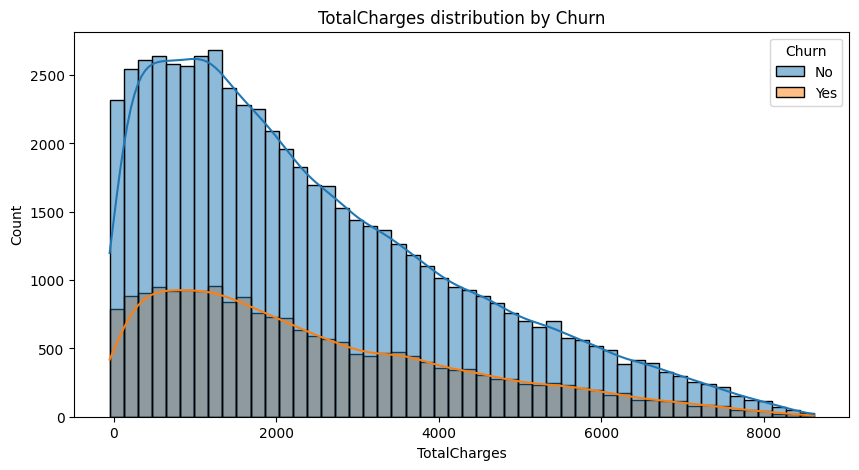

In [288]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='TotalCharges', hue='Churn', bins=50, kde=True)
plt.title('TotalCharges distribution by Churn')
plt.xlabel('TotalCharges')
plt.show()

Findings from EDA:

- As Tenure increases, Total charges also increase.
- Churn rate is highest for Fiber optic users.
- The amount of customers getting churned is less than half of customers not getting churned.
- Higher churn rates for people with low total charges, i.e. many customers leave early.

In [289]:
df["AvgMonthlySpend"] = df["TotalCharges"] / df["Tenure"].replace(0, 1)
df["HasDependentsAndPartner"] = df.apply(
    lambda x: 1 if (x["Partner"] == "Yes" and x["Dependents"] == "Yes") else 0, axis=1
)

In [290]:
numeric_features = ["Tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [
    "Gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "InternetService",
]

In [291]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [292]:
X = df.drop(columns=['Churn'])
y = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [293]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=500, solver='saga', class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',  
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("\nBest RF Params:", grid_search.best_params_)
print("Best RF Score (weighted F1):", grid_search.best_score_)

smote_rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_rf.named_steps['classifier'].n_estimators,
        max_depth=best_rf.named_steps['classifier'].max_depth,
        min_samples_split=best_rf.named_steps['classifier'].min_samples_split,
        random_state=42,
        n_jobs=-1
    ))
])

smote_rf_pipeline.fit(X_train, y_train)
y_pred_smote = smote_rf_pipeline.predict(X_test)
y_proba_smote = smote_rf_pipeline.predict_proba(X_test)[:,1]

print("\n===== Random Forest + SMOTE =====")
print(classification_report(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.74      0.48      0.58     14791
           1       0.26      0.53      0.35      5209

    accuracy                           0.49     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.62      0.49      0.52     20000

ROC AUC: 0.5001268327952176

===== Random Forest =====
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     14791
           1       0.26      0.12      0.17      5209

    accuracy                           0.68     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.62      0.68      0.64     20000

ROC AUC: 0.5008112847026476

===== Gradient Boosting =====
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     14791
           1       0.29      0.00      0.00      5209

    accuracy                       

===== Classification Report (Final Model) =====
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     14791
           1       0.26      0.29      0.28      5209

    accuracy                           0.60     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.60      0.61     20000

ROC AUC Score: 0.5049282107818804


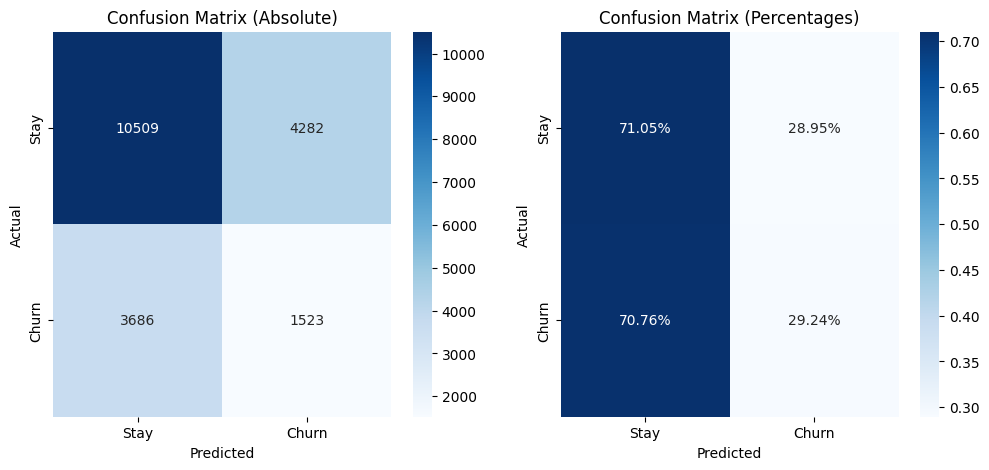


Top 10 Most Important Features:
                         feature  importance
             num__MonthlyCharges    0.343676
               num__TotalCharges    0.319824
                     num__Tenure    0.290451
              cat__Dependents_No    0.004290
             cat__Dependents_Yes    0.004277
cat__InternetService_Fiber optic    0.004169
        cat__InternetService_DSL    0.004035
                cat__Gender_Male    0.003759
              cat__Gender_Female    0.003712
                cat__Partner_Yes    0.003563


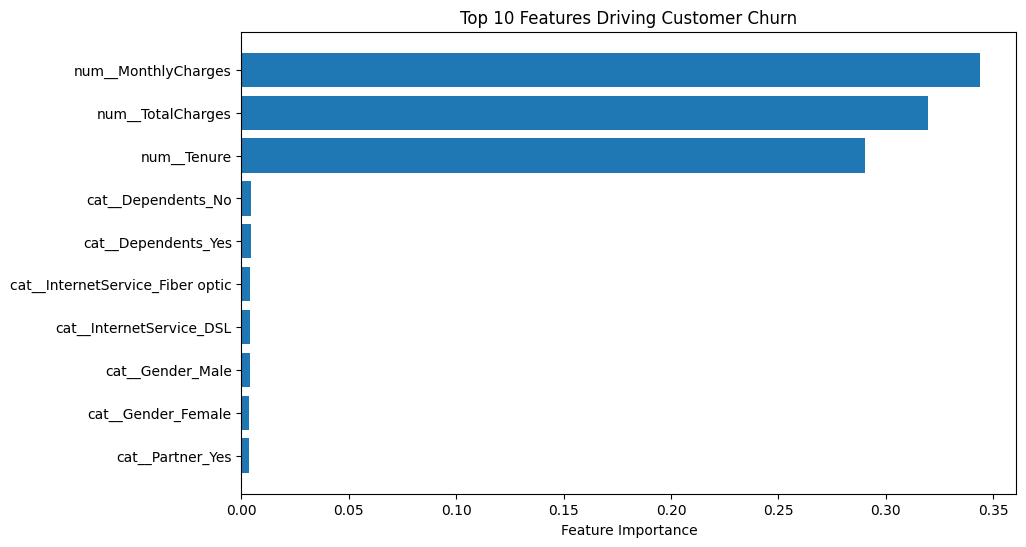

In [294]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

y_pred_final = smote_rf_pipeline.predict(X_test)
y_proba_final = smote_rf_pipeline.predict_proba(X_test)[:,1]

print("===== Classification Report (Final Model) =====")
print(classification_report(y_test, y_pred_final))

roc_auc = roc_auc_score(y_test, y_proba_final)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay','Churn'], yticklabels=['Stay','Churn'])
plt.title("Confusion Matrix (Absolute)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Stay','Churn'], yticklabels=['Stay','Churn'])
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

"""
- False Positive (FP): Predicted churn, but customer stays → unnecessary retention cost.
- False Negative (FN): Predicted stay, but customer churns → lost revenue and customer.

Business impact: FN is worse because missing a churner means losing a customer.
"""

rf_model = smote_rf_pipeline.named_steps['classifier']

try:
    feature_names = smote_rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    n_features = rf_model.feature_importances_.shape[0]
    feature_names = [f'feature_{i}' for i in range(n_features)]

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(10)
print("\nTop 10 Most Important Features:")
print(top_features.to_string(index=False))

plt.figure(figsize=(10,6))
bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel("Feature Importance")
plt.title("Top 10 Features Driving Customer Churn")
plt.gca().invert_yaxis()
plt.show()


Top 3 features in predicting customer churn are Monthly charges, Total Charges and Tenure.
In prediction of customer churn, False negative(predicting a customer will stay when they actually churn) is more costly than False positive(predicting a customer will churn when they actually stay).Because False Negatives result in lost revenue,while false positive will only result in unnecessary efforts to retain a customer who will stay.